In [1]:
# Simple CNN for the MNIST Dataset
import numpy
import tensorflow as tf
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.utils import to_categorical
# fix dimension ordering issue
from tensorflow.python.keras import backend as K
print(K.image_data_format())

from tensorflow.contrib.tensorboard.plugins import projector

import matplotlib.pyplot as plt
import os.path

import numpy as np

channels_last


In [2]:
LOG_DIR = './embeddings_logs'

## Obtain MNIST data

In [3]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


## Generate Metadata for Embeddings

### Generate image sprites

In [4]:
# extract images to sprite
images_to_sprite = X_test

images_to_sprite.shape

(10000, 28, 28)

In [5]:
COLUMNS = 100

#test for partial row

if (images_to_sprite.shape[0] % COLUMNS) != 0:
    number_images_to_fill = COLUMNS - \
            (images_to_sprite.shape[0] % COLUMNS)
    images_to_sprite = np.vstack([images_to_sprite,
              np.zeros([number_images_to_fill,28,28])])

images_to_sprite.shape

(10000, 28, 28)

In [6]:
rows = np.ceil(images_to_sprite.shape[0] / float(COLUMNS)).astype('int')
rows

100

In [7]:
sprite_image = np.vstack([np.hstack(images_to_sprite[r*COLUMNS:(r+1)*COLUMNS]) 
     for r in range(rows)])

sprite_image.shape

(2800, 2800)

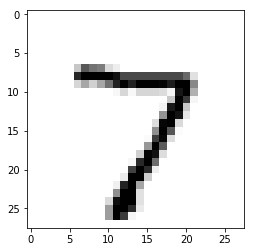

In [8]:
plt.imshow(sprite_image[:28,:28],cmap='Greys')
plt.show()

In [9]:
plt.imsave(os.path.join(LOG_DIR,'mnist_sprite.png'),sprite_image,cmap='Greys')

### Generate digit label metadata

In [10]:
digits = y_test
digits.shape

(10000,)

In [11]:
with open(os.path.join(LOG_DIR,'mnist_labels.tsv'),'w') as f:
    f.write('Class\tName\n')
    for i in range(digits.shape[0]):
        f.write('{}\t{}\n'.format(digits[i],str(digits[i])))

## Generate image embeddings

In [12]:
# reshape to be [samples][channels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28,1).astype('float32')

print(X_train.shape,X_test.shape)

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [13]:
# restore the model
model = load_model('./mnist_model')

In [14]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________
None

In [15]:
#remove last layer
model.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
Total params: 590,784
Trainable params: 590,784
Non-trainable params: 0
_________________________________________________________________


In [16]:
# generate image embeddings
features = tf.Variable(model.predict(X_test), name='features')

## Setup for use of Tensorboard

In [19]:
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'embeddings.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = 'mnist_labels.tsv'
    # Comment out if you don't want sprites
    embedding.sprite\
        .image_path = 'mnist_sprite.png'
    embedding.sprite\
        .single_image_dim.extend([28,28])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)




In [23]:
config.embeddings._values

[tensor_name: "features:0"
 metadata_path: "mnist_labels.tsv"
 sprite {
   image_path: "mnist_sprite.png"
   single_image_dim: 28
   single_image_dim: 28
 }]